# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

Now that you understand the key ideas behind linear regression,
we can begin to work through a hands-on implementation in code.
In this section, (**we will implement the entire method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
While modern deep learning frameworks can automate nearly all of this work,
implementing things from scratch is the only way
to make sure that you really know what you are doing.
Moreover, when it comes time to customize models,
defining our own layers or loss functions,
understanding how things work under the hood will prove handy.
In this section, we will rely only on tensors and auto differentiation.
Afterwards, we will introduce a more concise implementation,
taking advantage of bells and whistles of deep learning frameworks.


In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

/tmp/ipykernel_10126/3937499902.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
import jax
from jax import numpy as jnp, random
import d2l
print("Using jax", jax.__version__)
jax.local_devices()

Using jax 0.3.13


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [4]:
import random
import torch


## Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]
Our task will be to recover this model's parameters
using the finite set of examples contained in our dataset.
We will keep the data low-dimensional so we can visualize it easily.
In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

You could think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold and thus
that $\epsilon$ obeys a normal distribution with mean of 0.
To make our problem easy, we will set its standard deviation to 0.01.
The following code generates our synthetic dataset.


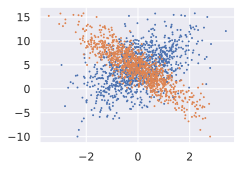

In [4]:
def synthetic_data(key, w, b, num_examples):
    """Generate y = Xw + b + noise."""
    key_sample, key_noise = random.split(key)
    X = random.normal(key_sample, (num_examples, len(w)))
    y = jnp.dot(X, w) + b
    y +=  0.01 * random.normal(key_noise, (1,))
    return X, y

initial_key = random.PRNGKey(0)
k1, k2 = random.split(initial_key)
 
true_w = jnp.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(k1, true_w, true_b, 1000)

d2l.set_figsize()
d2l.plt.scatter(features[:,0], labels, s=1);
d2l.plt.scatter(features[:,1], labels, s=1);

In [ ]:
# Set problem dimensions.
n_samples = 20
x_dim = 10
y_dim = 5

# Generate random ground truth W and b.
key = random.PRNGKey(0)
k1, k2 = random.split(key)
W = random.normal(k1, (x_dim, y_dim))
b = random.normal(k2, (y_dim,))

# Generate samples with additional noise.
key_sample, key_noise = random.split(k1)
x_samples = random.normal(key_sample, (n_samples, x_dim))
y_samples = predict(W, b, x_samples) + 0.1 * random.normal(key_noise,(n_samples, y_dim))
print('x shape:', x_samples.shape, '; y shape:', y_samples.shape)

In [42]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [43]:
true_w = torch.tensor([2, -3.4])
len(true_w)

2

In [44]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that [**each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar).**]


In [45]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.7779,  0.0585]) 
label: tensor([2.4486])


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


In [24]:
features_np = features[:, (1)].detach().numpy()
labels_np = labels.detach().numpy()
features_np.shape

(1000,)

In [ ]:
from matplotlib import pyplot as plt


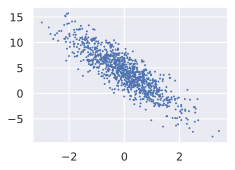

In [46]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## Reading the Dataset

Recall that training models consists of
making multiple passes over the dataset,
grabbing one minibatch of examples at a time,
and using them to update our model.
Since this process is so fundamental
to training machine learning algorithms,
it is worth defining a utility function
to shuffle the dataset and access it in minibatches.

In the following code, we [**define the `data_iter` function**] (~~that~~)
to demonstrate one possible implementation of this functionality.
The function (**takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`.**)
Each minibatch consists of a tuple of features and labels.


In [17]:
import numpy as np
from torch.utils.data import Dataset, DataLoader


class RegressionDataset(Dataset):
    
    
    def __init__(self, features, labels):
        self.features = np.array(features)
        self.labels = np.array(labels)
        
        
    def __len__(self):
        return len(self.labels)
    
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        x = self.features[idx]
        return {"x": x, "y": y}


def data_iter(batch_size, features, labels):
    ds = RegressionDataset(features, labels)
    dl = DataLoader(ds, batch_size=10, shuffle=True)
    for (idx, batch) in enumerate(dl):
        yield jnp.array(batch['x']), jnp.array(batch['y'])
        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[-1.854445    0.02839056]
 [-1.436208    1.6992846 ]
 [ 0.96133417  0.32950047]
 [-0.6461938   1.1098987 ]
 [ 1.1393408   1.4918703 ]
 [ 0.6267178   0.98163193]
 [-0.2375904   0.17593713]
 [-0.37634265 -0.73730016]
 [ 0.42299855 -2.0566092 ]
 [ 1.3906918  -0.2460602 ]] 
 [ 0.3887155 -4.455851   4.9965    -0.8719101  1.4004557  2.1100202
  3.1207662  5.9482684 12.032601   7.8121214]


In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In general, note that we want to use reasonably sized minibatches
to take advantage of the GPU hardware,
which excels at parallelizing operations.
Because each example can be fed through our models in parallel
and the gradient of the loss function for each example can also be taken in parallel,
GPUs allow us to process hundreds of examples in scarcely more time
than it might take to process just a single example.

To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each minibatch tells us
both the minibatch size and the number of input features.
Likewise, our minibatch of labels will have a shape given by `batch_size`.


In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.0999,  0.4855],
        [ 1.9538,  1.0919],
        [ 1.5107, -0.2886],
        [ 0.9734, -0.2309],
        [ 0.6716, -1.0258],
        [-0.9730, -0.7290],
        [-0.6671, -0.8925],
        [-0.7708, -0.3410],
        [ 0.0294, -1.2729],
        [-0.7009,  0.5991]]) 
 tensor([[0.3487],
        [4.4049],
        [8.1914],
        [6.9287],
        [9.0329],
        [4.7465],
        [5.9153],
        [3.8213],
        [8.5887],
        [0.7470]])


As we run the iteration, we obtain distinct minibatches
successively until the entire dataset has been exhausted (try this).
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us in trouble on real problems.
For example, it requires that we load all the data in memory
and that we perform lots of random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient and they can deal
with both data stored in files and data fed via data streams.


## Initializing Model Parameters

[**Before we can begin optimizing our model's parameters**] by minibatch stochastic gradient descent,
(**we need to have some parameters in the first place.**)
In the following code, we initialize weights by sampling
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01, and setting the bias to 0.


In [63]:
# Generate random ground truth W and b.
key = random.PRNGKey(0)
k1, k2 = random.split(key)
w = 0.1 * random.normal(k1, (2, 1))
b = jnp.zeros((1,))
w, b

(DeviceArray([[-0.00495003],
              [-0.07115594]], dtype=float32),
 DeviceArray([0.], dtype=float32))

In [51]:
import torch
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0039],
         [ 0.0054]], requires_grad=True),
 tensor([0.], requires_grad=True))

After initializing our parameters,
our next task is to update them until
they fit our data sufficiently well.
Each update requires taking the gradient
of our loss function with respect to the parameters.
Given this gradient, we can update each parameter
in the direction that may reduce the loss.

Since nobody wants to compute gradients explicitly
(this is tedious and error prone),
we use automatic differentiation,
as introduced in :numref:`sec_autograd`, to compute the gradient.


## Defining the Model

Next, we must [**define our model,
relating its inputs and parameters to its outputs.**]
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar.
Recall the broadcasting mechanism as described in :numref:`subsec_broadcasting`.
When we add a vector and a scalar,
the scalar is added to each component of the vector.


In [18]:
def linreg(X, w, b): return jnp.dot(X, w) + b

In [ ]:
# Loss function: Mean squared error.
def mse(W, b, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    y_pred = predict(W, b, x)
    return jnp.inner(y-y_pred, y-y_pred) / 2.0
  # We vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched), axis=0)


In [9]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

## Defining the Loss Function

Since [**updating our model requires taking
the gradient of our loss function,**]
we ought to (**define the loss function first.**)
Here we will use the squared loss function
as described in :numref:`sec_linear_regression`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [19]:
def squared_loss(y_hat, y):
    def squared_error(y_hat_one, y_one): return jnp.inner(y_one-y_hat_one, y_one-y_hat_one) / 2.0
    return jnp.mean(jax.vmap(squared_error)(y_hat, y), axis=0)

In [10]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [20]:
def predict(w, b, x): return jnp.dot(x, w) + b

# Loss function: Mean squared error.
def mse(w, b, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    y_pred = predict(w, b, x)
    return jnp.inner(y-y_pred, y-y_pred) / 2.0
  # We vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched), axis=0)

## Defining the Optimization Algorithm

As we discussed in :numref:`sec_linear_regression`,
linear regression has a closed-form solution.
However, this is not a book about linear regression:
it is a book about deep learning.
Since none of the other models that this book introduces
can be solved analytically, we will take this opportunity to introduce your first working example of
minibatch stochastic gradient descent.
[~~Despite linear regression has a closed-form solution, other models in this book don't. Here we introduce minibatch stochastic gradient descent.~~]

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.
The following code applies the minibatch stochastic gradient descent update,
given a set of parameters, a learning rate, and a batch size.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the minibatch of examples,
we normalize our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.


In [21]:
@jax.jit
def sgd(w, b, x, y, lr):
  w, b = w - lr * jax.grad(mse, 0)(w, b, x, y), b - lr * jax.grad(mse, 1)(w, b, x, y)
  return w, b

In [ ]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

Now that we have all of the parts in place,
we are ready to [**implement the main training loop.**]
It is crucial that you understand this code
because you will see nearly identical training loops
over and over again throughout your career in deep learning.

In each iteration, we will grab a minibatch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will call the optimization algorithm `sgd`
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters,
which we set here to 3 and 0.03, respectively.
Unfortunately, setting hyperparameters is tricky
and requires some adjustment by trial and error.
We elide these details for now but revise them
later in
:numref:`chap_optimization`.


In [64]:
batch_size = 10
learning_rate = 0.03
num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        w, b = sgd(w, b, X, y, learning_rate)
    train_l = mse(w, b, features, labels)
    print(f'epoch {epoch + 1}, loss {train_l:f}')

epoch 1, loss 0.027159
epoch 2, loss 0.000043
epoch 3, loss 0.000000


In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035526
epoch 2, loss 0.000131
epoch 3, loss 0.000050


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [65]:
true_w, w, true_b, b

(DeviceArray([ 2. , -3.4], dtype=float32),
 DeviceArray([[ 1.9999237],
              [-3.3998275]], dtype=float32),
 4.2,
 DeviceArray([4.1938157], dtype=float32))

In [58]:
print(f'error in estimating w: {true_w - w}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [[ 2.3841858e-07 -5.3999996e+00]
 [ 5.4000001e+00  0.0000000e+00]]
error in estimating b: [0.00587273]


In [14]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([1.6928e-05, 1.8287e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0004], grad_fn=<RsubBackward1>)


Note that we should not take it for granted
that we are able to recover the parameters perfectly.
However, in machine learning, we are typically less concerned
with recovering true underlying parameters,
and more concerned with parameters that lead to highly accurate prediction.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

* We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.
* This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.


## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work?
1. Assume that you are
   [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model between voltage and current. Can you use auto differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density?
1. What are the problems you might encounter if you wanted to  compute the second derivatives? How would you fix them?
1.  Why is the `reshape` function needed in the `squared_loss` function?
1. Experiment using different learning rates to find out how fast the loss function value drops.
1. If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?


[Discussions](https://discuss.d2l.ai/t/43)
